In [1]:
import os
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from time import time, localtime
import numpy as np
from utils import plot_graph
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras import losses, metrics, optimizers
import random
import pandas as pd
import sys
import matplotlib.pyplot as plt
import nest_asyncio
from pathlib import Path
from checkpoint_manager import FileCheckpointManager
import tensorflow_addons as tfa
from tensorflow import keras
from keras.layers import TimeDistributed, Conv1D, MaxPool1D, Flatten, LSTM, Dense, AveragePooling1D
from keras.models import Sequential
np.set_printoptions(threshold=sys.maxsize) 
nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)


In [2]:
def train_test_split(df, frac=0.2):
    selected = df['flow_id'].drop_duplicates().sample(frac=frac)
    test = df[df['flow_id'].isin(selected)]
    train = df[~df['flow_id'].isin(selected)]
    return train, test

In [3]:
def test_case_split(df,split):
    selected = df['flow_id'].drop_duplicates().sample(frac=1)
    # print(selected.shape)
    total_data_count = selected.shape[0]
    data_per_set = int(np.floor(total_data_count/split))
    DataFrameDict = {}
    for i in range(1, split+1):
        client_name = "client_" + str(i)
        start = data_per_set * (i-1)
        end = data_per_set * i

        print(f"Adding data from {start} to {end} for client : {client_name}")
        DataFrameDict[client_name] = df[df['flow_id'].isin(selected[start:end])]
    return DataFrameDict

Lựa chọn model <br>
Thay models.<Ten_model>

In [4]:
from models.CNN_2D_L2_WO_Drop_v3 import create_keras_model


Thay đổi các siêu tham số trong cell dưới <br>
**experiment_name:** Tên bộ dữ liệu được sử dụng, <Tên dữ liệu>_<Số byte sử dụng> <br>
**method:** Mô hình sử dụng <br>
**client_lr, server_lr:** Learning rate của client và server, khi fine tune bắt đầu từ 1 và giảm dần xuống 3e-4 <br>
**NUM_ROUNDS:** Số vòng lặp (Bắt đầu từ 1 và tăng dần lên 3000 nếu mô hình chưa hội tụ - 1/100/200/300/400/500/.../3000) <Br>
**BATCH_SIZE:** Kích thước batch (Bắt đầu từ 8 và tăng dần lên 64) 8/16/32/64 <br>
**split:** Để nguyên là 5

byte_number (string): Cac byte cua packet, bao gom 10, 32, 64, 128, 256, 512, 1024, 1460

In [5]:
byte_number = "512"


In [47]:
experiment_name = "GQUIC_" + byte_number
method = "CNN_2D_L2_WO_Drop_v3"
client_lr = 3e-4
server_lr = 3e-4
NUM_ROUNDS = 1000
BATCH_SIZE = 32
split = 5


In [7]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method
output_dir = this_dir / "sdn_results" / experiment_name / method

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)


In [8]:
def sec_to_hours(seconds):
    a = seconds//3600
    b = (seconds % 3600)//60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d


In [9]:
def most_frequent(List):
    return max(set(List), key=List.count)


### Đọc dữ liệu

In [10]:
train_dir = '/home/onos/FL/Data_Processing/GQUIC_small/Train/GQUIC_data_' + byte_number + '.feather'
test_dir = '/home/onos/FL/Data_Processing/GQUIC_small/Test//GQUIC_test_' + byte_number + '.feather'
data = pd.read_feather(train_dir)
test = pd.read_feather(test_dir)


In [11]:
result = test.groupby('flow_id')['Label'].apply(list).to_dict()
flow_label = []
for flow in result:
    flow_label.append(most_frequent(result[flow]))

flow_label = np.array(flow_label)
true_test = test.drop('flow_id', axis=1)
NUM_FEATURE = len(true_test.columns)-1
NUM_CLASSES = len(np.unique(true_test['Label']))
print(NUM_FEATURE, NUM_CLASSES)

512 4


In [12]:
y_test = true_test['Label'].to_numpy()
x_test = true_test.drop('Label', axis=1).to_numpy()
x_test = x_test.reshape(-1,20,NUM_FEATURE,1)
DataFrameDict = test_case_split(data,split)

Adding data from 0 to 2224 for client : client_1
Adding data from 2224 to 4448 for client : client_2
Adding data from 4448 to 6672 for client : client_3
Adding data from 6672 to 8896 for client : client_4
Adding data from 8896 to 11120 for client : client_5


## Federated Learning Approach

### Data Loading

In [13]:
def make_tf_dataset(dataframe, batch_size=None):

    result = dataframe.groupby('flow_id')['Label'].apply(list).to_dict()
    y = []
    for flow in result:
        y.append(most_frequent(result[flow]))
    y = np.array(y)
    y = y.reshape(-1,1)
    dataframe = dataframe.drop(['Label','flow_id'], axis=1).to_numpy()/255
    dataframe = dataframe.reshape(-1, 20, NUM_FEATURE)
    dataframe = np.expand_dims(dataframe,-1)
    dataset = tf.data.Dataset.from_tensor_slices((dataframe, y))
    if batch_size:
        dataset = dataset.batch(batch_size)
    return dataset


In [14]:
train_data, val_data = [], []
for client_data in DataFrameDict.keys():
    train_df, val_df = train_test_split(DataFrameDict[client_data], frac=0.2)
    # TF Datasets
    train_data.append(make_tf_dataset(train_df, batch_size=BATCH_SIZE))
    val_data.append(make_tf_dataset(val_df, batch_size=1))


### Model Definition

In [15]:
def input_spec():
    return (
        tf.TensorSpec([None, 20, NUM_FEATURE,1], tf.float64),
        tf.TensorSpec([None, 1], tf.int64)
    )


In [16]:
def model_fn():
    model = create_keras_model(NUM_FEATURE, NUM_CLASSES)

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


### Training

Each time the `next` method is called, the server model is broadcast to each client using a broadcast function. For each client, one epoch of local training is performed. Each client computes the difference between the client model after training and the initial broadcast model. These model deltas are then aggregated at the server using some aggregation function.

In [17]:
tff_train_acc = []
tff_train_loss = []
tff_val_acc = []
tff_val_loss = []


In [18]:
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(
        learning_rate=client_lr),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(
        learning_rate=server_lr)
)


In [19]:
evaluator = tff.learning.build_federated_evaluation(model_fn)


In [20]:
state = iterative_process.initialize()


In [21]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%y_%m_%d_%H_%M")
print("Current Time =", current_time)


Current Time = 22_12_10_22_49


In [ ]:
current_round = None

In [23]:
# ckpt_manager = FileCheckpointManager(
#     model_dir/"22_10_31_02_09"/"{}_{}".format(experiment_name, method))
# state,current_round = ckpt_manager.load_latest_checkpoint(state)


In [24]:
ckpt_manager = FileCheckpointManager(
    model_dir/current_time/"{}_{}".format(experiment_name, method), keep_total=10)


In [25]:
if not current_round:
    current_round = 0


In [48]:
start = time()
for i in range(current_round, NUM_ROUNDS):
    # Train
    result = iterative_process.next(state, train_data)
    state = result.state
    train_metrics = result.metrics['client_work']['train']

    # Validation
    federated_metrics = evaluator(result.state.global_model_weights, val_data)
    val_metrics = federated_metrics['eval']

    # Metrics
    train_loss = train_metrics['loss']
    train_acc = train_metrics['sparse_categorical_accuracy']
    val_loss = val_metrics['loss']
    val_acc = val_metrics['sparse_categorical_accuracy']

    # Print
    print('round {:2d}\ntrain_loss={l:.3f}, train_acc={ac:.3f}'.format(
        i+1, l=train_loss, ac=train_metrics['sparse_categorical_accuracy']))
    print('val_loss: {:.3f} val_acc: {:.3f}'.format(
        val_loss, val_acc))

    # Save
    if i > 1 and float(val_metrics['loss']) <= min(tff_val_loss):
        try:
            ckpt_manager.save_checkpoint(state, round_num=i)
        except:
            print("File exist")
    # logs
    tff_train_acc.append(float(train_metrics['sparse_categorical_accuracy']))
    tff_train_loss.append(float(train_metrics['loss']))
    tff_val_acc.append(float(val_metrics['sparse_categorical_accuracy']))
    tff_val_loss.append(float(val_metrics['loss']))
    current_round = i




round 573
train_loss=0.079, train_acc=0.973
val_loss: 0.176 val_acc: 0.947
round 574
train_loss=0.080, train_acc=0.973
val_loss: 0.176 val_acc: 0.947
round 575
train_loss=0.080, train_acc=0.973
val_loss: 0.176 val_acc: 0.947
round 576
train_loss=0.079, train_acc=0.974
val_loss: 0.174 val_acc: 0.947
round 577
train_loss=0.080, train_acc=0.973
val_loss: 0.173 val_acc: 0.949
round 578
train_loss=0.079, train_acc=0.975
val_loss: 0.172 val_acc: 0.949
round 579
train_loss=0.078, train_acc=0.974
val_loss: 0.171 val_acc: 0.950
round 580
train_loss=0.078, train_acc=0.974
val_loss: 0.170 val_acc: 0.950
round 581
train_loss=0.079, train_acc=0.974
val_loss: 0.170 val_acc: 0.950
round 582
train_loss=0.078, train_acc=0.974
val_loss: 0.170 val_acc: 0.951
round 583
train_loss=0.079, train_acc=0.974
val_loss: 0.171 val_acc: 0.950
round 584
train_loss=0.077, train_acc=0.974
val_loss: 0.171 val_acc: 0.950
round 585
train_loss=0.075, train_acc=0.976
val_loss: 0.171 val_acc: 0.949
round 586
train_loss=0.07

In [49]:
end = time() - start

In [50]:
total_time = "Time: {}".format(sec_to_hours(end))
print(total_time)


Time: 16 hours 13 mins 11 seconds


In [51]:
train_val = str(round(train_acc*100)) + "_" + str(round(val_acc*100))


In [52]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method / train_val
output_dir = this_dir / "sdn_results" / experiment_name / method / train_val

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)


### Evaluation

In [53]:
ckpt_manager = FileCheckpointManager(model_dir)
try:
    ckpt_manager.save_checkpoint(state, round_num=current_round)
except:
    print("File exist")


In [54]:
with open(output_dir/'parameters.txt', 'w') as f:
    print('client_lr: {}\nserver_lr: {}\nRounds: {}\nBATCH_SIZE: {}'.format(
        client_lr, server_lr, current_round, BATCH_SIZE), file=f)
    f.close()


In [55]:
text_file = open(output_dir/"time.txt", "w")
n = text_file.write(total_time)
text_file.close()


In [56]:
model_for_inference = create_keras_model(NUM_FEATURE, NUM_CLASSES)
state.global_model_weights.assign_weights_to(model_for_inference)


In [57]:
predictions = model_for_inference.predict(x_test, batch_size=64)


44/44 [==============================] - 7s 156ms/step


In [58]:
flow_pred = np.argmax(predictions, axis=-1)

In [59]:
one_flow = x_test[0].reshape(-1,20,NUM_FEATURE,1)
start = time()
predictions_1flow = model_for_inference.predict(one_flow)
one_flow_pred = np.argmax(predictions_1flow, axis=-1)
end = time() - start
print(one_flow_pred)
print(end)

1/1 [==============================] - 0s 85ms/step
[1]
0.17957019805908203


In [60]:
model_for_inference.save(model_dir/'model.h5')

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


classes = []
for c in range(NUM_CLASSES):
    classes.append("Class {}".format(c))
print(classes)
with open(output_dir/'metrics.txt', 'w') as f:
    confusion = confusion_matrix(flow_label, flow_pred)
    print('Confusion Matrix\n', file=f)
    print(confusion, file=f)

    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(
        accuracy_score(flow_label, flow_pred)), file=f)

    print('Micro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='micro')), file=f)
    print('Micro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='micro')), file=f)
    print(
        'Micro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='micro')), file=f)

    print('Macro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='macro')), file=f)
    print('Macro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='macro')), file=f)
    print(
        'Macro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='macro')), file=f)

    print('Weighted Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='weighted')), file=f)
    print('Weighted Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='weighted')), file=f)
    print(
        'Weighted F1-score: {:.2f}'.format(f1_score(flow_label, flow_pred, average='weighted')), file=f)

    print('\nClassification Report\n', file=f)
    print(classification_report(flow_label, flow_pred, target_names=classes), file=f)
    f.close()


['Class 0', 'Class 1', 'Class 2', 'Class 3']


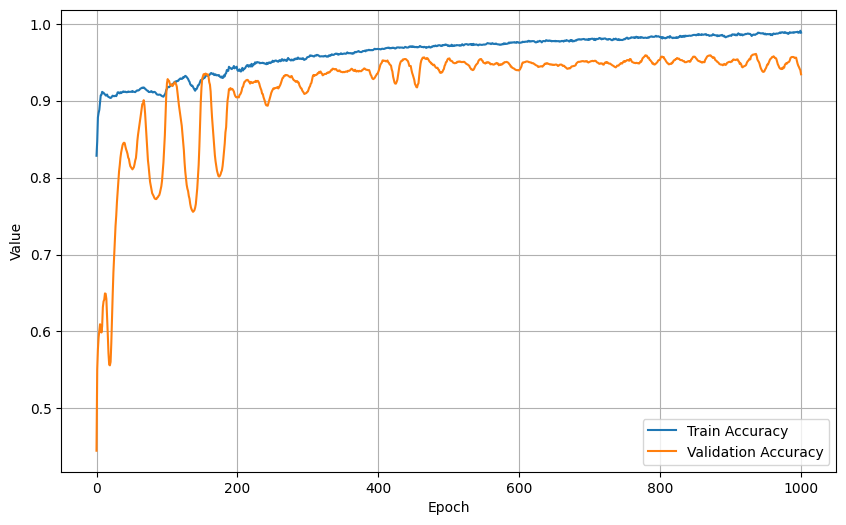

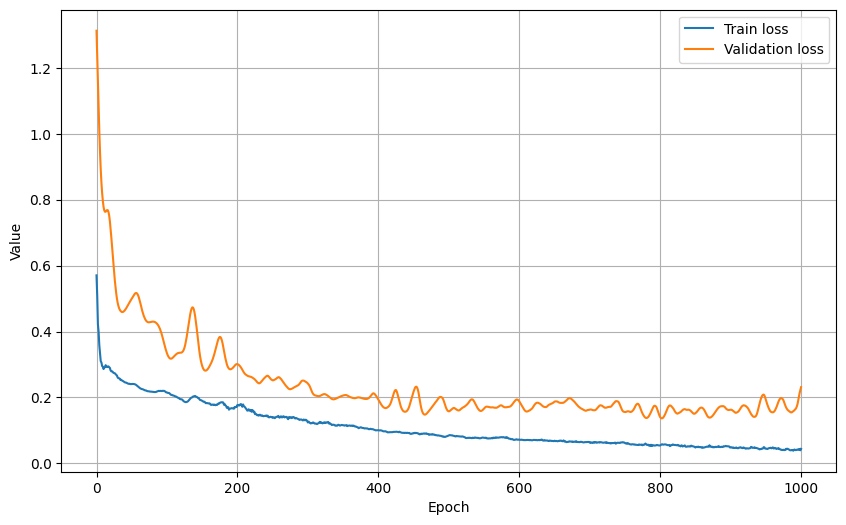

In [67]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(0, current_round+1)),
           tff_train_acc, label='Train Accuracy')
plot_graph(list(range(0, current_round+1)), tff_val_acc,
           label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(0, current_round+1)), tff_train_loss, label='Train loss')
plot_graph(list(range(0, current_round+1)),
           tff_val_loss, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model_loss.png")


In [68]:
max(tff_val_acc)

0.9608988761901855

In [69]:
tff_val_acc.index(max(tff_val_acc))

936

In [70]:
max(tff_train_acc)

0.9910061955451965